# 1. 环境设置与导入库
首先，我们需要导入所有必要的库，并设置设备（CPU 或 GPU）。

In [2]:
# Cell 1: 环境设置与导入库

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda


# 2. 数据集类与预处理
定义 CelebADataset 类，并设置图像预处理方法。

In [3]:
# Cell 2: 数据集类与预处理

# CelebA数据集类
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 transform=None, partition=0):
        """
        初始化数据集
        :param img_dir: 图像文件夹路径
        :param attr_path: 属性文件路径
        :param bbox_path: 边界框文件路径
        :param partition_path: 分区文件路径
        :param transform: 图像预处理
        :param partition: 使用的数据分区 (0: train, 1: val, 2: test)
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取属性文件
        attr_df = pd.read_csv(attr_path, sep=',', header=0)
        partition_df = pd.read_csv(partition_path, sep=',', header=0)
        
        # 合并属性文件和分区文件
        attr_df = attr_df.merge(partition_df, on='image_id')
        
        # 根据指定的分区进行筛选
        self.attr_df = attr_df[attr_df['partition'] == partition]
        
        # 读取边界框文件
        bbox_df = pd.read_csv(bbox_path, sep=',', header=0)
        
        # 合并边界框信息
        self.attr_df = self.attr_df.merge(bbox_df, on='image_id')

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        # 获取图像文件名
        img_name = self.attr_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像并转换为RGB
        image = Image.open(img_path).convert('RGB')
        
        # 获取属性标签 
        attrs = self.attr_df.iloc[idx, 1:41].values
        attrs = (attrs + 1) // 2  # 将-1转为0，1保持1
        attrs = attrs.astype(np.float32)
        
        # 应用图像预处理
        if self.transform:
            image = self.transform(image)
        
        # 随机选择一个CLIP文本嵌入
        random_idx = random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)
        clip_embedding = CLIP_TEXT_EMBEDDINGS[random_idx]
        
        return image, attrs, clip_embedding

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])


# 3. 加载CLIP模型与预计算文本嵌入
加载 CLIP 模型并预先计算文本嵌入，以提高训练效率。

In [4]:
# Cell 3: 加载CLIP模型与预计算文本嵌入

# 加载CLIP模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 文本提示词
TEXT_PROMPTS = [
    "A portrait of a young woman",
    "A realistic face with a smile",
    "A person with distinct facial features"
]

# 生成CLIP文本嵌入（提前计算以避免重复计算）
def generate_text_embeddings(text_prompts):
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
    return text_embeddings.cpu()  # 移动到CPU

# 预先计算文本嵌入
CLIP_TEXT_EMBEDDINGS = generate_text_embeddings(TEXT_PROMPTS)


# 4. 数据加载器设置
设置训练集和验证集的数据加载器。

In [5]:
# Cell 4: 数据加载器设置

# 数据集路径设置（请根据实际路径修改）
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'

# 创建训练集和验证集
train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            transform=transform, partition=1)

# 数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


# 5. 模型定义
定义 ClipCVAE 模型结构。

In [6]:
# Cell 5: 模型定义

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar


# 6. 初始化模型、损失函数和优化器

In [7]:
# Cell 6: 初始化模型、损失函数和优化器

# 初始化模型参数
latent_dim = 128
cond_dim = 40
clip_dim = 512
model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                cond_dim=cond_dim, clip_dim=clip_dim).to(device)

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 损失函数
criterion = nn.MSELoss(reduction='sum')

# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL


# 7. 训练与验证函数
定义训练和验证的函数，并记录每个epoch的损失。



In [8]:
# Cell 7: 训练与验证函数

def train_model(model, train_loader, val_loader, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch}, 平均训练损失: {avg_train_loss:.4f}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model, train_losses, val_losses


# 8. 图像生成与可视化函数
定义生成图像和显示图像的函数。

In [9]:
# Cell 8: 图像生成与可视化函数

# 图像生成函数
def generate_images(model, attrs, text_prompts, device, num_images=16):
    """
    根据条件标签和文本提示生成图像
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        
        # 对于每个图像随机选择一个文本嵌入
        text_embeddings = torch.stack([
            CLIP_TEXT_EMBEDDINGS[random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)] 
            for _ in range(num_images)
        ]).to(device)
        
        generated = model.decode(z, attrs, text_embeddings)
        generated = generated.cpu()
        return generated

# 可视化生成的图像
def show_images(images, title="Generated Images"):
    images = images * 0.5 + 0.5  # 反归一化
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()


# 9. 实验1：固定轮次，多次训练并记录损失
在固定的训练轮次下，多次训练模型，并记录每次训练的训练和验证损失，以计算平均收敛点。

In [10]:
# Cell 9: 实验1 - 固定轮次，多次训练

import copy

# 设置实验参数
fixed_num_epochs = 20  # 固定的训练轮次
num_runs = 5  # 多次训练的次数

# 存储所有运行的损失
all_train_losses = []
all_val_losses = []

for run in range(1, num_runs + 1):
    print(f"\n=== 运行 {run}/{num_runs} ===")
    
    # 重新初始化模型和优化器
    model_run = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                        cond_dim=cond_dim, clip_dim=clip_dim).to(device)
    optimizer_run = optim.Adam(model_run.parameters(), lr=1e-3)
    
    # 训练模型
    trained_model, train_losses, val_losses = train_model(
        model_run, train_loader, val_loader, optimizer_run, num_epochs=fixed_num_epochs
    )
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    
    # 释放显存
    del trained_model
    torch.cuda.empty_cache()

# 计算平均损失
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)

# 绘制平均损失曲线
plt.figure(figsize=(10,5))
plt.plot(range(1, fixed_num_epochs + 1), avg_train_losses, label='平均训练损失')
plt.plot(range(1, fixed_num_epochs + 1), avg_val_losses, label='平均验证损失')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.title(f'固定轮次({fixed_num_epochs})下的平均损失曲线（{num_runs}次训练）')
plt.legend()
plt.show()



=== 运行 1/5 ===


Epoch 1/20:  73%|███████▎  | 934/1272 [00:49<00:17, 18.92it/s]


KeyboardInterrupt: 


=== Run 1/5 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:10<00:00, 18.11it/s]

Epoch 1, 平均训练损失: 1250.0539


验证集平均损失: 696.0651


Epoch 2/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.36it/s]

Epoch 2, 平均训练损失: 599.7074


验证集平均损失: 549.8893


Epoch 3/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.99it/s]

Epoch 3, 平均训练损失: 531.4929


验证集平均损失: 515.4673


Epoch 4/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.42it/s]

Epoch 4, 平均训练损失: 505.2019


验证集平均损失: 484.7446


Epoch 5/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.06it/s]

Epoch 5, 平均训练损失: 490.9708


验证集平均损失: 474.8995


Epoch 6/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.28it/s]

Epoch 6, 平均训练损失: 472.4658


验证集平均损失: 466.8100


Epoch 7/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.63it/s]

Epoch 7, 平均训练损失: 461.8855


验证集平均损失: 454.0345


Epoch 8/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.75it/s]

Epoch 8, 平均训练损失: 454.9061


验证集平均损失: 455.0431


Epoch 9/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.74it/s]

Epoch 9, 平均训练损失: 450.9630


验证集平均损失: 451.3741


Epoch 10/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.90it/s]

Epoch 10, 平均训练损失: 445.6571


验证集平均损失: 451.3233


Epoch 11/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.91it/s]

Epoch 11, 平均训练损失: 442.1619


验证集平均损失: 441.9029


Epoch 12/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.00it/s]

Epoch 12, 平均训练损失: 439.0753


验证集平均损失: 439.1686


Epoch 13/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.26it/s]

Epoch 13, 平均训练损失: 436.1761


验证集平均损失: 435.7756


Epoch 14/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.90it/s]

Epoch 14, 平均训练损失: 434.3574


验证集平均损失: 439.5575


Epoch 15/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.58it/s]

Epoch 15, 平均训练损失: 431.7308


验证集平均损失: 432.5664


Epoch 16/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.12it/s]

Epoch 16, 平均训练损失: 430.1591


验证集平均损失: 437.1438


Epoch 17/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.64it/s]

Epoch 17, 平均训练损失: 428.3923


验证集平均损失: 429.1922


Epoch 18/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.99it/s]

Epoch 18, 平均训练损失: 427.1261


验证集平均损失: 429.1642


Epoch 19/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.93it/s]

Epoch 19, 平均训练损失: 426.0967


验证集平均损失: 426.2995


Epoch 20/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.79it/s]

Epoch 20, 平均训练损失: 424.2279


验证集平均损失: 435.6235

=== Run 2/5 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.47it/s]

Epoch 1, 平均训练损失: 1165.7525


验证集平均损失: 639.6504


Epoch 2/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.47it/s]

Epoch 2, 平均训练损失: 583.1369


验证集平均损失: 536.3967


Epoch 3/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.63it/s]

Epoch 3, 平均训练损失: 522.1387


验证集平均损失: 517.5310


Epoch 4/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.34it/s]

Epoch 4, 平均训练损失: 503.4757


验证集平均损失: 487.1916


Epoch 5/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.90it/s]

Epoch 5, 平均训练损失: 482.3172


验证集平均损失: 471.2472


Epoch 6/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.75it/s]

Epoch 6, 平均训练损失: 468.9188


验证集平均损失: 466.1715


Epoch 7/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.01it/s]

Epoch 7, 平均训练损失: 461.3679


验证集平均损失: 456.1844


Epoch 8/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.62it/s]

Epoch 8, 平均训练损失: 453.8929


验证集平均损失: 452.8669


Epoch 9/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.77it/s]

Epoch 9, 平均训练损失: 449.2460


验证集平均损失: 441.8677


Epoch 10/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.45it/s]

Epoch 10, 平均训练损失: 444.9618


验证集平均损失: 443.2024


Epoch 11/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.04it/s]

Epoch 11, 平均训练损失: 442.4809


验证集平均损失: 442.0965


Epoch 12/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.20it/s]

Epoch 12, 平均训练损失: 438.5309


验证集平均损失: 437.8276


Epoch 13/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.26it/s]

Epoch 13, 平均训练损失: 436.9488


验证集平均损失: 438.1756


Epoch 14/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.80it/s]

Epoch 14, 平均训练损失: 434.9080


验证集平均损失: 434.7976


Epoch 15/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.35it/s]

Epoch 15, 平均训练损失: 432.6701


验证集平均损失: 436.3827


Epoch 16/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.14it/s]

Epoch 16, 平均训练损失: 431.3478


验证集平均损失: 438.3308


Epoch 17/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.23it/s]

Epoch 17, 平均训练损失: 429.7890


验证集平均损失: 430.0643


Epoch 18/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.53it/s]

Epoch 18, 平均训练损失: 427.9340


验证集平均损失: 426.8953


Epoch 19/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.25it/s]

Epoch 19, 平均训练损失: 426.8018


验证集平均损失: 426.3826


Epoch 20/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.00it/s]

Epoch 20, 平均训练损失: 425.3244


验证集平均损失: 433.7504

=== Run 3/5 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.01it/s]

Epoch 1, 平均训练损失: 1170.8782


验证集平均损失: 659.5147


Epoch 2/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.95it/s]

Epoch 2, 平均训练损失: 582.7526


验证集平均损失: 548.5422


Epoch 3/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.81it/s]

Epoch 3, 平均训练损失: 524.4993


验证集平均损失: 507.8003


Epoch 4/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.91it/s]

Epoch 4, 平均训练损失: 502.0920


验证集平均损失: 490.3049


Epoch 5/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.39it/s]

Epoch 5, 平均训练损失: 488.4706


验证集平均损失: 480.2113


Epoch 6/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.68it/s]

Epoch 6, 平均训练损失: 474.5364


验证集平均损失: 465.9797


Epoch 7/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.54it/s]

Epoch 7, 平均训练损失: 464.3930


验证集平均损失: 454.4232


Epoch 8/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.19it/s]

Epoch 8, 平均训练损失: 457.0389


验证集平均损失: 457.3866


Epoch 9/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.56it/s]

Epoch 9, 平均训练损失: 450.4482


验证集平均损失: 452.1370


Epoch 10/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.06it/s]

Epoch 10, 平均训练损失: 446.3669


验证集平均损失: 446.9985


Epoch 11/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.75it/s]

Epoch 11, 平均训练损失: 442.6127


验证集平均损失: 437.8262


Epoch 12/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.15it/s]

Epoch 12, 平均训练损失: 439.2715


验证集平均损失: 436.1511


Epoch 13/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.83it/s]

Epoch 13, 平均训练损失: 437.0458


验证集平均损失: 436.1571


Epoch 14/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.96it/s]

Epoch 14, 平均训练损失: 435.3093


验证集平均损失: 434.4697


Epoch 15/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.81it/s]

Epoch 15, 平均训练损失: 432.8921


验证集平均损失: 432.4816


Epoch 16/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.56it/s]

Epoch 16, 平均训练损失: 431.1794


验证集平均损失: 430.4019


Epoch 17/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.36it/s]

Epoch 17, 平均训练损失: 429.0893


验证集平均损失: 427.2340


Epoch 18/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.90it/s]

Epoch 18, 平均训练损失: 427.7218


验证集平均损失: 429.6546


Epoch 19/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.66it/s]

Epoch 19, 平均训练损失: 426.1802


验证集平均损失: 428.0678


Epoch 20/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.23it/s]

Epoch 20, 平均训练损失: 424.9828


验证集平均损失: 427.5341

=== Run 4/5 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.22it/s]

Epoch 1, 平均训练损失: 1229.8295


验证集平均损失: 691.3087


Epoch 2/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.23it/s]

Epoch 2, 平均训练损失: 596.0838


验证集平均损失: 565.4037


Epoch 3/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.36it/s]

Epoch 3, 平均训练损失: 530.8767


验证集平均损失: 522.0408


Epoch 4/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.98it/s]

Epoch 4, 平均训练损失: 505.9076


验证集平均损失: 497.5216


Epoch 5/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.94it/s]

Epoch 5, 平均训练损失: 490.2419


验证集平均损失: 482.3718


Epoch 6/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.32it/s]

Epoch 6, 平均训练损失: 476.6254


验证集平均损失: 465.3234


Epoch 7/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.02it/s]

Epoch 7, 平均训练损失: 465.5717


验证集平均损失: 463.2155


Epoch 8/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.11it/s]

Epoch 8, 平均训练损失: 458.4812


验证集平均损失: 450.4321


Epoch 9/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.37it/s]

Epoch 9, 平均训练损失: 452.9466


验证集平均损失: 451.0049


Epoch 10/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.73it/s]

Epoch 10, 平均训练损失: 448.0889


验证集平均损失: 457.2352


Epoch 11/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.49it/s]

Epoch 11, 平均训练损失: 444.7697


验证集平均损失: 443.7838


Epoch 12/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.64it/s]

Epoch 12, 平均训练损失: 441.7728


验证集平均损失: 443.2977


Epoch 13/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.37it/s]

Epoch 13, 平均训练损失: 439.0026


验证集平均损失: 439.8035


Epoch 14/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.69it/s]

Epoch 14, 平均训练损失: 436.9663


验证集平均损失: 439.9349


Epoch 15/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.84it/s]

Epoch 15, 平均训练损失: 434.0730


验证集平均损失: 434.5132


Epoch 16/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.96it/s]

Epoch 16, 平均训练损失: 432.7421


验证集平均损失: 433.3596


Epoch 17/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.41it/s]

Epoch 17, 平均训练损失: 430.7444


验证集平均损失: 432.1709


Epoch 18/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.01it/s]

Epoch 18, 平均训练损失: 429.6325


验证集平均损失: 435.8672


Epoch 19/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.59it/s]

Epoch 19, 平均训练损失: 427.5977


验证集平均损失: 436.2132


Epoch 20/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.77it/s]

Epoch 20, 平均训练损失: 426.8376


验证集平均损失: 429.3253

=== Run 5/5 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.74it/s]

Epoch 1, 平均训练损失: 1247.9009


验证集平均损失: 676.4828


Epoch 2/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.45it/s]

Epoch 2, 平均训练损失: 593.8847


验证集平均损失: 540.3705


Epoch 3/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.04it/s]

Epoch 3, 平均训练损失: 530.0168


验证集平均损失: 507.2923


Epoch 4/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.39it/s]

Epoch 4, 平均训练损失: 504.1361


验证集平均损失: 490.3311


Epoch 5/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.27it/s]

Epoch 5, 平均训练损失: 488.6957


验证集平均损失: 477.9861


Epoch 6/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.60it/s]

Epoch 6, 平均训练损失: 472.8302


验证集平均损失: 468.1880


Epoch 7/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.45it/s]

Epoch 7, 平均训练损失: 462.3420


验证集平均损失: 455.2011


Epoch 8/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.43it/s]

Epoch 8, 平均训练损失: 455.4163


验证集平均损失: 454.6974


Epoch 9/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.49it/s]

Epoch 9, 平均训练损失: 450.4745


验证集平均损失: 458.4212


Epoch 10/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.02it/s]

Epoch 10, 平均训练损失: 446.1699


验证集平均损失: 455.6496


Epoch 11/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.34it/s]

Epoch 11, 平均训练损失: 443.1647


验证集平均损失: 445.4107


Epoch 12/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.05it/s]

Epoch 12, 平均训练损失: 439.4736


验证集平均损失: 439.6269


Epoch 13/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.41it/s]

Epoch 13, 平均训练损失: 438.1445


验证集平均损失: 438.2372


Epoch 14/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.51it/s]

Epoch 14, 平均训练损失: 434.8448


验证集平均损失: 434.5687


Epoch 15/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.39it/s]

Epoch 15, 平均训练损失: 433.2073


验证集平均损失: 431.2304


Epoch 16/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.08it/s]

Epoch 16, 平均训练损失: 431.5919


验证集平均损失: 433.3172


Epoch 17/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.35it/s]

Epoch 17, 平均训练损失: 429.9045


验证集平均损失: 429.0365


Epoch 18/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.24it/s]

Epoch 18, 平均训练损失: 428.0881


验证集平均损失: 429.8655


Epoch 19/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.44it/s]

Epoch 19, 平均训练损失: 426.9853


验证集平均损失: 429.2654


Epoch 20/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.58it/s]

Epoch 20, 平均训练损失: 425.7904


验证集平均损失: 427.3673


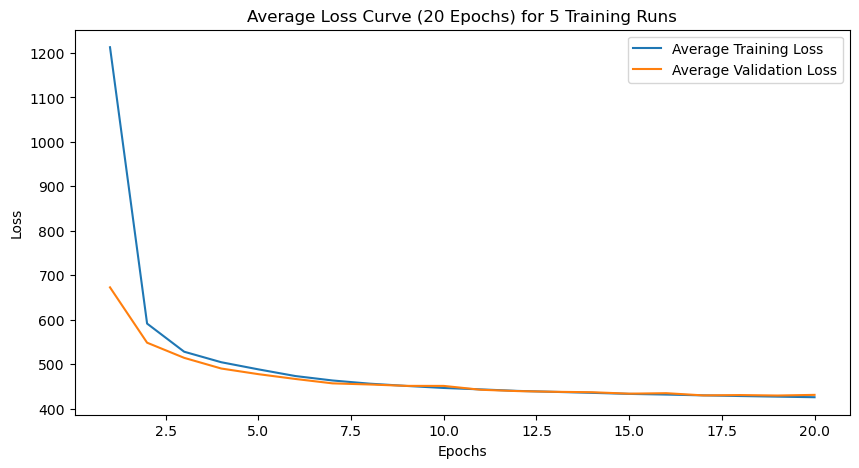

In [ ]:
# Cell 9: Experiment 1 - Fixed Epochs, Multiple Trainings

import copy

# Set experiment parameters
fixed_num_epochs = 20  # Fixed number of training epochs
num_runs = 5  # Number of training runs

# Store all run losses
all_train_losses = []
all_val_losses = []

for run in range(1, num_runs + 1):
    print(f"\n=== Run {run}/{num_runs} ===")
    
    # Reinitialize the model and optimizer
    model_run = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                        cond_dim=cond_dim, clip_dim=clip_dim).to(device)
    optimizer_run = optim.Adam(model_run.parameters(), lr=1e-3)
    
    # Train the model
    trained_model, train_losses, val_losses = train_model(
        model_run, train_loader, val_loader, optimizer_run, num_epochs=fixed_num_epochs
    )
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    
    # Free up memory
    del trained_model
    torch.cuda.empty_cache()

# Calculate average loss
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)

# Plot average loss curve
plt.figure(figsize=(10,5))
plt.plot(range(1, fixed_num_epochs + 1), avg_train_losses, label='Average Training Loss')
plt.plot(range(1, fixed_num_epochs + 1), avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Average Loss Curve ({fixed_num_epochs} Epochs) for {num_runs} Training Runs')
plt.legend()
plt.show()


# 10. 实验2：改变轮次，多次训练并寻找最佳轮次
在多个不同的训练轮次下进行多次训练，记录每个轮次的平均损失，并分析最佳轮次。

In [ ]:
# Cell 10: 实验2 - 改变轮次，寻找最佳轮次

# 设置实验参数
epoch_options = [10, 20, 30, 40, 50]  # 不同的训练轮次选项
num_runs_per_epoch = 3  # 每个轮次进行的训练次数

# 存储不同轮次的损失
epoch_train_losses = {epochs: [] for epochs in epoch_options}
epoch_val_losses = {epochs: [] for epochs in epoch_options}

for epochs in epoch_options: 
    print(f"\n=== 训练轮次: {epochs} ===")
    for run in range(1, num_runs_per_epoch + 1):
        print(f"--- 运行 {run}/{num_runs_per_epoch} ---")
        
        # 重新初始化模型和优化器
        model_run = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                            cond_dim=cond_dim, clip_dim=clip_dim).to(device)
        optimizer_run = optim.Adam(model_run.parameters(), lr=1e-3)
        
        # 训练模型
        trained_model, train_losses, val_losses = train_model(
            model_run, train_loader, val_loader, optimizer_run, num_epochs=epochs
        )
        
        # 记录最后一个epoch的损失
        epoch_train_losses[epochs].append(train_losses[-1])
        epoch_val_losses[epochs].append(val_losses[-1])
        
        # 释放显存
        del trained_model
        torch.cuda.empty_cache()

# 计算每个轮次的平均损失
avg_epoch_train_losses = {epochs: np.mean(losses) for epochs, losses in epoch_train_losses.items()}
avg_epoch_val_losses = {epochs: np.mean(losses) for epochs, losses in epoch_val_losses.items()}

# 绘制不同轮次的平均验证损失
epochs_sorted = sorted(epoch_options)
val_loss_means = [avg_epoch_val_losses[epochs] for epochs in epochs_sorted]

plt.figure(figsize=(10,5))
plt.plot(epochs_sorted, val_loss_means, marker='o', label='平均验证损失')
plt.xlabel('训练轮次')
plt.ylabel('平均验证损失')
plt.title('不同训练轮次下的平均验证损失')
plt.xticks(epochs_sorted)
plt.legend()
plt.show()

# 打印最佳轮次
best_epoch = epochs_sorted[np.argmin(val_loss_means)]
print(f"最佳训练轮次为: {best_epoch}, 对应的平均验证损失为: {avg_epoch_val_losses[best_epoch]:.4f}")



=== 训练轮次: 10 ===
--- 运行 1/3 ---


NameError: name 'ClipCVAE' is not defined

# 11. 保存模型与生成图像
在确定最佳轮次后，可以保存最终模型并生成一些示例图像。


=== 使用最佳轮次 20 重新训练模型 ===


Epoch 1/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.05it/s]

Epoch 1, 平均训练损失: 1130.0552


验证集平均损失: 651.1227


Epoch 2/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.97it/s]

Epoch 2, 平均训练损失: 572.8847


验证集平均损失: 527.8121


Epoch 3/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.17it/s]

Epoch 3, 平均训练损失: 520.4011


验证集平均损失: 505.6527


Epoch 4/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.65it/s]

Epoch 4, 平均训练损失: 498.1894


验证集平均损失: 489.3199


Epoch 5/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.32it/s]

Epoch 5, 平均训练损失: 482.0067


验证集平均损失: 474.4076


Epoch 6/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.80it/s]

Epoch 6, 平均训练损失: 468.3415


验证集平均损失: 462.9390


Epoch 7/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.43it/s]

Epoch 7, 平均训练损失: 460.8985


验证集平均损失: 457.9579


Epoch 8/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.26it/s]

Epoch 8, 平均训练损失: 453.8006


验证集平均损失: 461.4393


Epoch 9/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.49it/s]

Epoch 9, 平均训练损失: 449.5267


验证集平均损失: 446.1807


Epoch 10/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.89it/s]

Epoch 10, 平均训练损失: 444.3329


验证集平均损失: 442.3183


Epoch 11/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.47it/s]

Epoch 11, 平均训练损失: 441.5948


验证集平均损失: 439.2494


Epoch 12/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.60it/s]

Epoch 12, 平均训练损失: 438.9171


验证集平均损失: 437.3713


Epoch 13/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.07it/s]

Epoch 13, 平均训练损失: 436.1112


验证集平均损失: 439.7210


Epoch 14/20: 100%|██████████| 1272/1272 [00:59<00:00, 21.36it/s]

Epoch 14, 平均训练损失: 433.8604


验证集平均损失: 436.4563


Epoch 15/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.30it/s]

Epoch 15, 平均训练损失: 432.3050


验证集平均损失: 434.2266


Epoch 16/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.26it/s]

Epoch 16, 平均训练损失: 429.9096


验证集平均损失: 431.2532


Epoch 17/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.31it/s]

Epoch 17, 平均训练损失: 428.6276


验证集平均损失: 428.6983


Epoch 18/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.60it/s]

Epoch 18, 平均训练损失: 427.1013


验证集平均损失: 427.4842


Epoch 19/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.27it/s]

Epoch 19, 平均训练损失: 425.6934


验证集平均损失: 426.6445


Epoch 20/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.45it/s]

Epoch 20, 平均训练损失: 424.6333


验证集平均损失: 432.1108
模型已保存为: clip_cvae_celeba_epochs_20.pth


/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

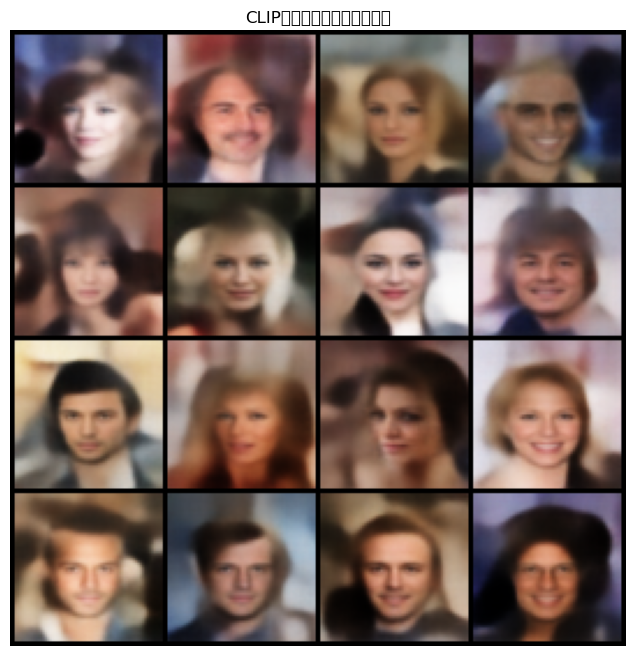

In [12]:
# Cell 11: 保存模型与生成图像

# 假设最佳轮次为 `best_epoch`
# 这里重新训练模型一次以获得最终模型
best_num_epochs = 20
print(f"\n=== 使用最佳轮次 {best_num_epochs} 重新训练模型 ===")

# 重新初始化模型和优化器
final_model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                      cond_dim=cond_dim, clip_dim=clip_dim).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

# 训练模型
final_trained_model, final_train_losses, final_val_losses = train_model(
    final_model, train_loader, val_loader, final_optimizer, num_epochs=best_num_epochs
)

# 保存模型
torch.save(final_trained_model.state_dict(), f'clip_cvae_celeba_epochs_{best_num_epochs}.pth')
print(f"模型已保存为: clip_cvae_celeba_epochs_{best_num_epochs}.pth")

# 生成图像示例
data_iter = iter(val_loader)
images, attrs, _ = next(data_iter)
sample_attrs = attrs[:16]

generated_images = generate_images(final_trained_model, sample_attrs, TEXT_PROMPTS, device, num_images=16)

# 可视化生成的图像
show_images(generated_images, title="CLIP引导的条件生成人脸图像")
